In [1]:
import os

%pwd

'd:\\work\\cifar100classifier-deep-learning\\research'

In [2]:
os.chdir('../')

%pwd

'd:\\work\\cifar100classifier-deep-learning'

In [3]:
import sys

sys.path.append('src')

%pwd

'd:\\work\\cifar100classifier-deep-learning'

In [4]:
# research workflow: trials -> config.yaml -> params.yaml -> data ingestion -> prepare base model -> prepare callbacks -> training -> model evaluation

from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    trained_model_path: Path
    updated_base_model_path: Path
    training_data: Path
    trainset_file: Path
    testset_file: Path
    num_classes: int
    params_epochs: int
    params_batch_size: int
    params_is_augmentation: bool
    params_image_size: list


@dataclass(frozen=True)
class PrepareCallbacksConfig:
    root_dir: Path
    tensorboard_root_log_dir: Path
    checkpoint_model_filepath: Path

In [5]:
import tensorflow as tf

from CNNClassifier.constants import *
from CNNClassifier.utils.utilities import read_yaml, create_directory


In [13]:
class ConfigurationManager:
    def __init__(self):
        self.config = read_yaml(CONFIG_FILE_PATH)
        self.params = read_yaml(PARAMS_FILE_PATH)
        create_directory([self.config.artifacts_root])

    def get_prepare_callback_config(self) -> PrepareCallbacksConfig:
        config = self.config.prepare_callbacks
        model_ckpt_dir = os.path.dirname(config.checkpoint_model_filepath)
        create_directory([
            Path(model_ckpt_dir),
            Path(config.tensorboard_root_log_dir)
        ])

        prepare_callback_config = PrepareCallbacksConfig(
            root_dir=Path(config.root_dir),
            tensorboard_root_log_dir=Path(config.tensorboard_root_log_dir),
            checkpoint_model_filepath=Path(config.checkpoint_model_filepath)
        )

        return prepare_callback_config
    
    def get_training_config(self) -> TrainingConfig:  # this is return value annotation
        training = self.config.training
        prepare_base_model = self.config.prepare_base_model
        params = self.params
        create_directory([Path(training.root_dir)])

        training_config = TrainingConfig(
            root_dir=Path(training.root_dir),
            trained_model_path=Path(training.trained_model_path),
            updated_base_model_path=Path(
                prepare_base_model.updated_base_model_path),
            training_data=Path(self.config.data_ingestion.unzip_dir),
            trainset_file=Path(self.config.data_ingestion.trainset_file),
            testset_file=Path(self.config.data_ingestion.testset_file),
            num_classes=params.CLASSES,
            params_epochs=params.EPOCHS,
            params_batch_size=params.BATCH_SIZE,
            params_is_augmentation=params.AUGMENTATION,
            params_image_size=params.IMAGE_SIZE
        )
        
        return training_config

In [14]:
import time
from livelossplot.inputs.keras import PlotLossesCallback

class PrepareCallback:
    def __init__(self, config: PrepareCallbacksConfig):
        self.config = config

    @property
    def _create_tb_callbacks(self):
        timestamp = time.strftime("%Y-%m-%d-%H-%M-%S")
        tb_running_log_dir = os.path.join(
            self.config.tensorboard_root_log_dir,
            f"tb_logs_at_{timestamp}",
        )
        return tf.keras.callbacks.TensorBoard(log_dir=tb_running_log_dir)
    
    @property
    def _create_ckpt_callbacks(self):
        checkpoint = tf.keras.callbacks.ModelCheckpoint(
            filepath=str(self.config.checkpoint_model_filepath),
            save_best_only=True,
            verbose=1
        )
        return checkpoint
    
    @property
    def _create_es_callbacks(self):
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=5, 
            restore_best_weights=True, 
            mode='min'
        )
        return early_stop
    
    @property
    def _create_plot_loss(self):
        return PlotLossesCallback()
    
    def callbacks(self):
        return [
            self._create_tb_callbacks,
            self._create_ckpt_callbacks,
            self._create_es_callbacks,
            self._create_plot_loss,
        ]

In [15]:
import pickle
import tensorflow as tf


class Training:
    def __init__(self, config: TrainingConfig):
        self.config = config
    
    def get_base_model(self):
        self.model = tf.keras.models.load_model(
            self.config.updated_base_model_path
        )
    
    def unpickle(self, file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='latin1')
        return dict
    
    def extract_data(self, dicts, num_classes):
        images = dicts['data']
        n = len(images)
        images = images.reshape(n, 3, 32, 32).transpose(0, 2, 3, 1)
        # take coarse and fine labels of the images
        c_labels = dicts['coarse_labels']
        f_labels = dicts['fine_labels']
        # transform label to categorical
        c_labels = tf.keras.utils.to_categorical(c_labels, num_classes)
        f_labels = tf.keras.utils.to_categorical(f_labels, num_classes)
        # normalize data
        # images = images/255
        return images, f_labels, c_labels
    
    def train_valid_generator(self):
        train_set = self.unpickle(os.path.join(self.config.training_data, self.config.trainset_file))
        x_train, y_train, _ = self.extract_data(train_set, self.config.num_classes)

        datagenerator_kwargs = dict(
            rescale = 1./255,
            validation_split=0.20
        )

        if self.config.params_is_augmentation:
            train_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=20,
                zoom_range=0.15,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.15,
                horizontal_flip=True,
                fill_mode="nearest",
                **datagenerator_kwargs
            )
        else:
            train_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                **datagenerator_kwargs
            )
        
        batch_size = self.config.params_batch_size

        self.train_generator = train_datagenerator.flow(x_train, y_train, batch_size=batch_size, subset='training', shuffle=False)
        self.valid_generator = train_datagenerator.flow(x_train, y_train, batch_size=batch_size, subset='validation', shuffle=False)
        self.samples = len(x_train)
        self.test_size = datagenerator_kwargs['validation_split']

    @staticmethod
    def save_model(path: Path, model: tf.keras.Model):
        model.save(path)

    def train(self, callback_list: list):
        self.steps_per_epoch = (self.samples*(1 - self.test_size)) // self.train_generator.batch_size
        self.validation_steps = (self.samples*self.test_size) // self.valid_generator.batch_size

        self.model.fit(
            self.train_generator,
            steps_per_epoch=self.steps_per_epoch,
            epochs=self.config.params_epochs,
            validation_data=self.valid_generator,
            validation_steps=self.validation_steps,
            callbacks=callback_list,
            verbose=1
        )

        self.save_model(
            path=self.config.trained_model_path,
            model=self.model
        )

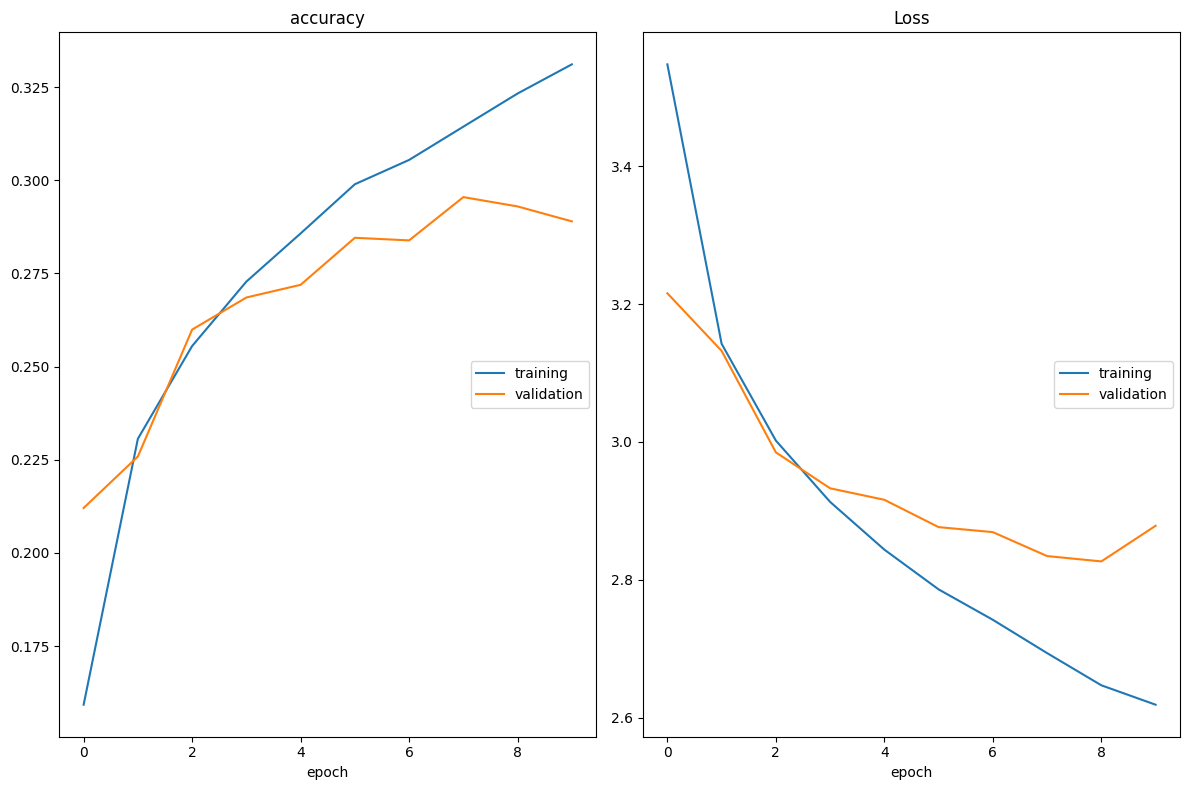

accuracy
	training         	 (min:    0.159, max:    0.331, cur:    0.331)
	validation       	 (min:    0.212, max:    0.295, cur:    0.289)
Loss
	training         	 (min:    2.619, max:    3.548, cur:    2.619)
	validation       	 (min:    2.827, max:    3.216, cur:    2.878)
625/625 [==============================] - 634s 1s/step - loss: 2.6187 - accuracy: 0.3311 - val_loss: 2.8783 - val_accuracy: 0.2890


In [16]:
try:
    config = ConfigurationManager()
    prepare_callbacks_config = config.get_prepare_callback_config()
    prepare_callbacks = PrepareCallback(config=prepare_callbacks_config)
    callback_list = prepare_callbacks.callbacks()
    training_config = config.get_training_config()
    training = Training(config=training_config)
    training.get_base_model()
    training.train_valid_generator()
    training.train(callback_list=callback_list)
except Exception as e:
    raise e